<a href="https://colab.research.google.com/github/Zanakkk/booksapi/blob/main/dentination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


In [ ]:
class_mapping = {
    "impaksi": 0,
    "tambalan": 1,
    "karies": 2,
    "prosto": 3,
    "rct": 4,
    "abses": 5,
    "kista": 6,
    "granuloma": 7,
    "implan": 8
}


In [ ]:
import json
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

# Fungsi untuk memuat gambar dan resize ke ukuran yang seragam
def load_image(image_path, target_size=(224, 132)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Resize gambar ke ukuran yang seragam
        image = image.convert('RGB')  # Pastikan gambar dalam format RGB
        return img_to_array(image)  # Konversi gambar ke array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Fungsi untuk memuat anotasi
def load_annotations(annotation_file):
    try:
        with open(annotation_file, 'r') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error reading JSON file: {e}")
        return []
    except FileNotFoundError as e:
        print(f"Annotation file not found: {e}")
        return []

# Fungsi untuk mempersiapkan data
def prepare_data(annotation_file, image_folder):
    annotations = load_annotations(annotation_file)
    images = []
    labels = []
    polygons = []  # To store polygons in original size

    # Mapping class labels to indices
    class_mapping = {
        "impaksi": 0,
        "tambalan": 1,
        "karies": 2,
        "prosto": 3,
        "rct": 4,
        "abses": 5,
        "kista": 6,
        "granuloma": 7,
        "implan": 8
    }

    # Loop through each item in the list of annotations
    for annotation in annotations:
        # annotation is a dictionary with a single key (e.g., '2024-76.jpg265191')
        for key, annotation_data in annotation.items():
            filename = annotation_data.get('filename')
            if filename:
                image_path = os.path.join(image_folder, filename)
                image = load_image(image_path)
                if image is not None:
                    images.append(image)

                    label = np.zeros(len(class_mapping))
                    image_polygons = []  # Store polygons in original size for each image

                    regions = annotation_data.get('regions', [])
                    for region in regions:
                        class_name = region['region_attributes'].get('gigi')
                        if class_name in class_mapping:
                            class_index = class_mapping[class_name]
                            label[class_index] = 1  # Multi-label classification

                        shape_attributes = region.get('shape_attributes', {})
                        all_points_x = shape_attributes.get('all_points_x')
                        all_points_y = shape_attributes.get('all_points_y')

                        if all_points_x and all_points_y:
                            image_polygons.append({
                                'all_points_x': all_points_x,
                                'all_points_y': all_points_y
                            })

                    polygons.append(image_polygons)
                    labels.append(label)
            else:
                print(f"Key 'filename' not found in annotation: {annotation_data}")

    return np.array(images), np.array(labels), polygons

# Example usage
annotation_file = 'anotate/testing.json'  # Path to the JSON annotation file
image_folder = 'data/testing'  # Path to the image folder

# Call the prepare_data function to process images and annotations
X_test, y_test, original_polygons = prepare_data(annotation_file, image_folder)

print("Number of images loaded:", len(X_test))
print("Number of labels loaded:", len(y_test))
print("Number of polygon sets loaded:", len(original_polygons))


Number of images loaded: 70
Number of labels loaded: 70
Number of polygon sets loaded: 70


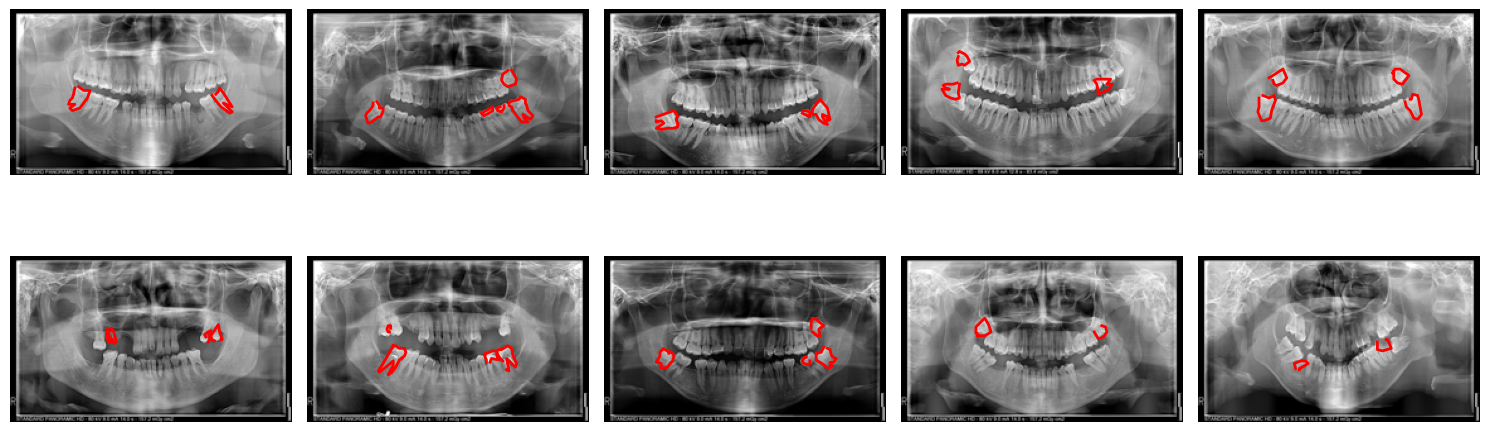

In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

# Fungsi untuk memuat gambar dan resize ke ukuran yang seragam
def load_image(image_path, target_size=(224, 132)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Resize gambar ke ukuran yang seragam
        image = image.convert('RGB')  # Pastikan gambar dalam format RGB
        return img_to_array(image)  # Konversi gambar ke array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Fungsi untuk memuat anotasi
def load_annotations(annotation_file):
    try:
        with open(annotation_file, 'r') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error reading JSON file: {e}")
        return []
    except FileNotFoundError as e:
        print(f"Annotation file not found: {e}")
        return []

# Fungsi untuk me-resize anotasi polygon berdasarkan ukuran gambar baru
def resize_polygons(original_polygons, original_size, target_size):
    resized_polygons = []
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    for polygons in original_polygons:
        resized_image_polygons = []
        for polygon in polygons:
            resized_points_x = [int(x * scale_x) for x in polygon['all_points_x']]
            resized_points_y = [int(y * scale_y) for y in polygon['all_points_y']]
            resized_image_polygons.append({
                'all_points_x': resized_points_x,
                'all_points_y': resized_points_y
            })
        resized_polygons.append(resized_image_polygons)

    return resized_polygons

# Fungsi untuk mempersiapkan data (gambar dan anotasi)
def prepare_data(annotation_file, image_folder, target_size=(224, 132), original_size=(1920, 1080)):
    annotations = load_annotations(annotation_file)
    images = []
    labels = []
    polygons = []  # To store polygons in original size

    # Mapping class labels to indices
    class_mapping = {
        "impaksi": 0,
        "tambalan": 1,
        "karies": 2,
        "prosto": 3,
        "rct": 4,
        "abses": 5,
        "kista": 6,
        "granuloma": 7,
        "implan": 8
    }

    for annotation in annotations:
        for key, annotation_data in annotation.items():
            filename = annotation_data.get('filename')
            if filename:
                image_path = os.path.join(image_folder, filename)
                image = load_image(image_path, target_size)
                if image is not None:
                    images.append(image)

                    label = np.zeros(len(class_mapping))
                    image_polygons = []  # Store polygons in original size for each image

                    regions = annotation_data.get('regions', [])
                    for region in regions:
                        class_name = region['region_attributes'].get('gigi')
                        if class_name in class_mapping:
                            class_index = class_mapping[class_name]
                            label[class_index] = 1  # Multi-label classification

                        shape_attributes = region.get('shape_attributes', {})
                        all_points_x = shape_attributes.get('all_points_x')
                        all_points_y = shape_attributes.get('all_points_y')

                        if all_points_x and all_points_y:
                            image_polygons.append({
                                'all_points_x': all_points_x,
                                'all_points_y': all_points_y
                            })

                    polygons.append(image_polygons)
                    labels.append(label)

    resized_polygons = resize_polygons(polygons, original_size, target_size)

    return np.array(images), np.array(labels), resized_polygons

# Fungsi untuk menampilkan 10 gambar random beserta anotasi polygon yang sudah diresize
def show_random_images_with_annotations(X_data, y_data, polygons, num_samples=10):
    random_indices = np.random.choice(len(X_data), num_samples, replace=False)

    random_X = X_data[random_indices]
    random_polygons = [polygons[i] for i in random_indices]

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(random_X[i].astype(np.uint8))

        for polygon in random_polygons[i]:
            all_points_x = polygon['all_points_x']
            all_points_y = polygon['all_points_y']
            ax.plot(all_points_x, all_points_y, 'r-', linewidth=2)

        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Contoh penggunaan
annotation_file = 'anotate/testing.json'
image_folder = 'data/testing'

# Misalkan ukuran asli gambar adalah 1920x1080
original_size = (2200, 1288)
# Target ukuran gambar setelah resize adalah 224x132
target_size = (224, 132)

# Memproses gambar dan anotasi
X_test, y_test, resized_polygons = prepare_data(annotation_file, image_folder, target_size, original_size)

# Menampilkan 10 gambar random beserta anotasinya yang sudah diresize
show_random_images_with_annotations(X_test, y_test, resized_polygons, num_samples=10)


In [ ]:
import json
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

# Fungsi untuk memuat gambar dan resize ke ukuran yang seragam
def load_image(image_path, target_size=(224, 132)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Pastikan ukuran gambar adalah (224, 132)
        image = image.convert('RGB')  # Konversi ke format RGB
        image_array = img_to_array(image)

        # Periksa apakah urutan dimensi sudah benar
        if image_array.shape != (224, 132, 3):
            # Jika bentuknya salah, tukar dimensi secara eksplisit
            image_array = np.transpose(image_array, (1, 0, 2))  # Tukar urutan tinggi dan lebar

        return image_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None



# Fungsi untuk memuat anotasi
def load_annotations(annotation_file):
    try:
        with open(annotation_file, 'r') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error reading JSON file: {e}")
        return []
    except FileNotFoundError as e:
        print(f"Annotation file not found: {e}")
        return []

# Fungsi untuk me-resize anotasi polygon berdasarkan ukuran gambar baru
def resize_polygons(original_polygons, original_size, target_size):
    resized_polygons = []
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    for polygons in original_polygons:
        resized_image_polygons = []
        for polygon in polygons:
            resized_points_x = [int(x * scale_x) for x in polygon['all_points_x']]
            resized_points_y = [int(y * scale_y) for y in polygon['all_points_y']]
            resized_image_polygons.append({
                'all_points_x': resized_points_x,
                'all_points_y': resized_points_y
            })
        resized_polygons.append(resized_image_polygons)

    return resized_polygons

# Fungsi untuk mempersiapkan data (gambar dan anotasi)
def prepare_data(annotation_file, image_folder, target_size=(224, 132), original_size=(1920, 1080)):
    annotations = load_annotations(annotation_file)
    images = []
    labels = []
    polygons = []  # To store polygons in original size

    # Mapping class labels to indices
    class_mapping = {
        "impaksi": 0,
        "tambalan": 1,
        "karies": 2,
        "prosto": 3,
        "rct": 4,
        "abses": 5,
        "kista": 6,
        "granuloma": 7,
        "implan": 8
    }

    for annotation in annotations:
        for key, annotation_data in annotation.items():
            filename = annotation_data.get('filename')
            if filename:
                image_path = os.path.join(image_folder, filename)
                image = load_image(image_path, target_size)
                if image is not None:
                    images.append(image)

                    label = np.zeros(len(class_mapping))
                    image_polygons = []  # Store polygons in original size for each image

                    regions = annotation_data.get('regions', [])
                    for region in regions:
                        class_name = region['region_attributes'].get('gigi')
                        if class_name in class_mapping:
                            class_index = class_mapping[class_name]
                            label[class_index] = 1  # Multi-label classification

                        shape_attributes = region.get('shape_attributes', {})
                        all_points_x = shape_attributes.get('all_points_x')
                        all_points_y = shape_attributes.get('all_points_y')

                        if all_points_x and all_points_y:
                            image_polygons.append({
                                'all_points_x': all_points_x,
                                'all_points_y': all_points_y
                            })

                    polygons.append(image_polygons)
                    labels.append(label)

    resized_polygons = resize_polygons(polygons, original_size, target_size)

    return np.array(images), np.array(labels), resized_polygons

# Fungsi untuk mempersiapkan data dari file JSON anotasi dan folder gambar terkait
def prepare_data_for_all_splits():
    # Path untuk data training, validation, dan testing
    annotation_train_file = 'anotate/training.json'
    image_train_folder = 'data/training'

    annotation_val_file = 'anotate/validation.json'
    image_val_folder = 'data/validation'

    annotation_test_file = 'anotate/testing.json'
    image_test_folder = 'data/testing'

    # Ukuran asli dan ukuran target untuk gambar
    original_size = (2200, 1288)
    target_size = (224, 132)

    # Memproses data training
    X_train, y_train, _ = prepare_data(annotation_train_file, image_train_folder, target_size, original_size)

    # Memproses data validation
    X_val, y_val, _ = prepare_data(annotation_val_file, image_val_folder, target_size, original_size)

    # Memproses data testing
    X_test, y_test, _ = prepare_data(annotation_test_file, image_test_folder, target_size, original_size)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Memanggil fungsi untuk mempersiapkan data
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data_for_all_splits()

# Verifikasi hasil data yang disiapkan
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)


(549, 549, 72, 72, 70, 70)

In [ ]:
pip install tensorflow


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menggunakan VGG16 dengan bobot pretrained dari ImageNet, dan menghapus top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 132, 3))

# Membuka beberapa layer terakhir dari VGG16 untuk fine-tuning
for layer in base_model.layers[-4:]:  # Membuka 4 layer terakhir dari VGG16
    layer.trainable = True

# Menambahkan lapisan custom di atas model VGG16
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout untuk regularisasi
output = Dense(9, activation='sigmoid')(x)  # Menggunakan sigmoid untuk multi-label classification

# Membuat model final
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile model dengan pengaturan optimizer dan loss function yang sesuai
model.compile(optimizer=Adam(learning_rate=0.001),  # Coba tingkatkan learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Membuat ImageDataGenerator untuk augmentasi data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Latih model dengan data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 4/18 ━━━━━━━━━━━━━━━━━━━━ 6:42 29s/step - accuracy: 0.0824 - loss: 5.7849

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load pretrained VGG16 with weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 132, 3))

# Freeze the pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization
output = Dense(9, activation='sigmoid')(x)  # Output layer for multi-label classification

# Compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 250s 14s/step - accuracy: 0.1880 - loss: 3.4978 - val_accuracy: 0.6111 - val_loss: 0.9957
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 242s 13s/step - accuracy: 0.2902 - loss: 1.5532 - val_accuracy: 0.6528 - val_loss: 0.7395
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 245s 14s/step - accuracy: 0.3025 - loss: 0.9604 - val_accuracy: 0.5556 - val_loss: 0.6063
Epoch 4/10
 2/18 ━━━━━━━━━━━━━━━━━━━━ 3:17 12s/step - accuracy: 0.2216 - loss: 0.6105

KeyboardInterrupt: 

In [ ]:
# Evaluasi model pada data testing
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.5975 - loss: 0.7775
Test accuracy: 0.5857142806053162


In [ ]:
# Menampilkan nilai akurasi dan loss secara eksplisit untuk setiap epoch
def print_history(history):
    # Mencetak nilai akurasi dan loss untuk setiap epoch
    for epoch in range(len(history.history['accuracy'])):
        print(f"Epoch {epoch+1}")
        print(f"Training Accuracy: {history.history['accuracy'][epoch]:.4f}")
        print(f"Validation Accuracy: {history.history['val_accuracy'][epoch]:.4f}")
        print(f"Training Loss: {history.history['loss'][epoch]:.4f}")
        print(f"Validation Loss: {history.history['val_loss'][epoch]:.4f}")
        print("---------------------------")

# Memanggil fungsi untuk mencetak nilai akurasi dan loss
print_history(history)


Epoch 1
Training Accuracy: 0.4062
Validation Accuracy: 0.7083
Training Loss: 1.4143
Validation Loss: 0.9472
---------------------------
Epoch 2
Training Accuracy: 0.4882
Validation Accuracy: 0.5417
Training Loss: 0.6753
Validation Loss: 0.6540
---------------------------
Epoch 3
Training Accuracy: 0.5883
Validation Accuracy: 0.5556
Training Loss: 0.4230
Validation Loss: 0.6238
---------------------------
Epoch 4
Training Accuracy: 0.5756
Validation Accuracy: 0.6111
Training Loss: 0.2892
Validation Loss: 0.6585
---------------------------
Epoch 5
Training Accuracy: 0.5956
Validation Accuracy: 0.5972
Training Loss: 0.1786
Validation Loss: 0.5700
---------------------------
Epoch 6
Training Accuracy: 0.6648
Validation Accuracy: 0.5556
Training Loss: 0.1160
Validation Loss: 0.5753
---------------------------
Epoch 7
Training Accuracy: 0.6321
Validation Accuracy: 0.5417
Training Loss: 0.0796
Validation Loss: 0.6276
---------------------------
Epoch 8
Training Accuracy: 0.6685
Validation Acc

In [ ]:
# Simpan model ke file
model.save('model/model_rontgen.h5')


3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step


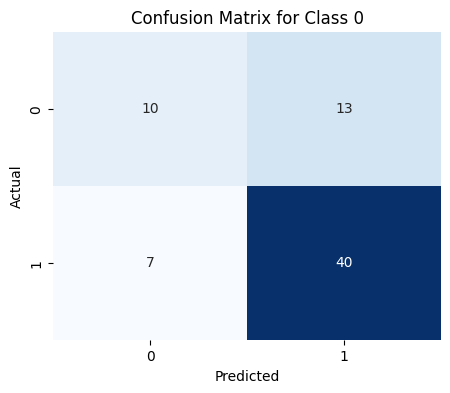

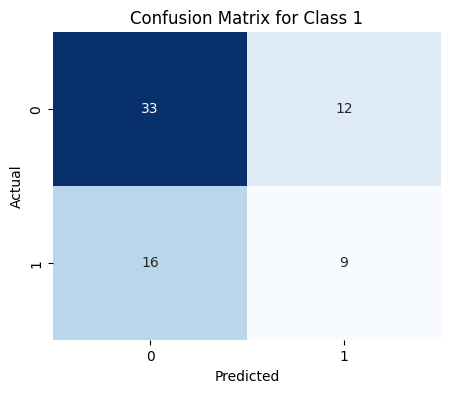

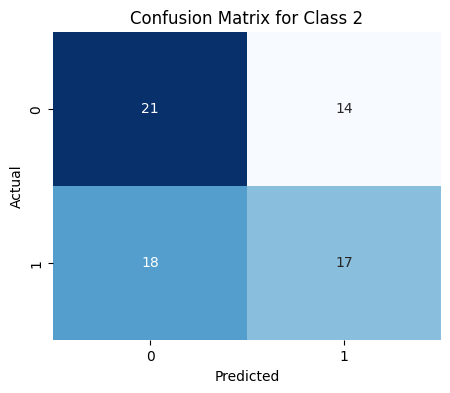

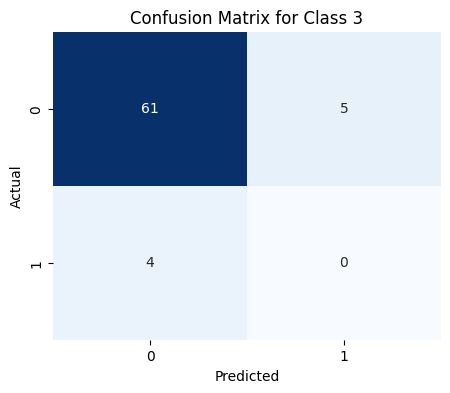

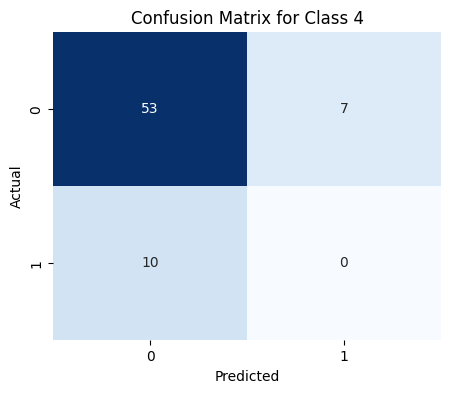

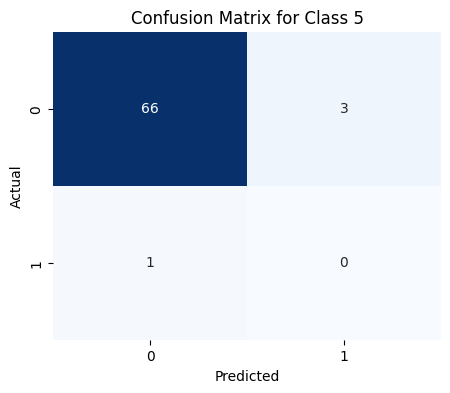

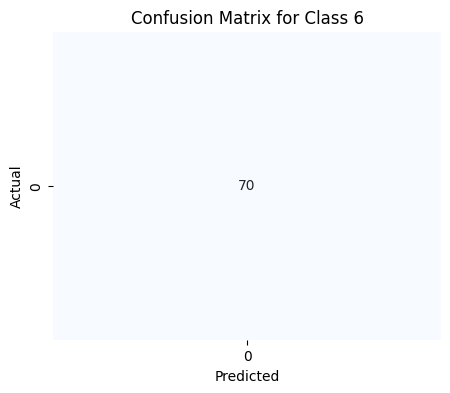

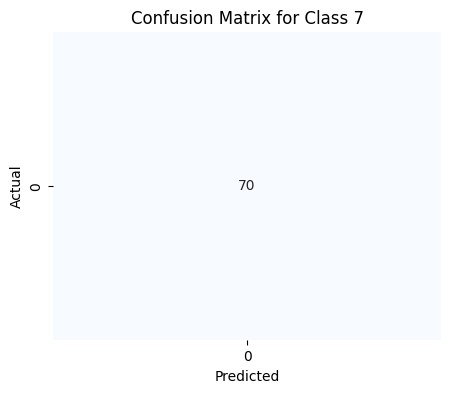

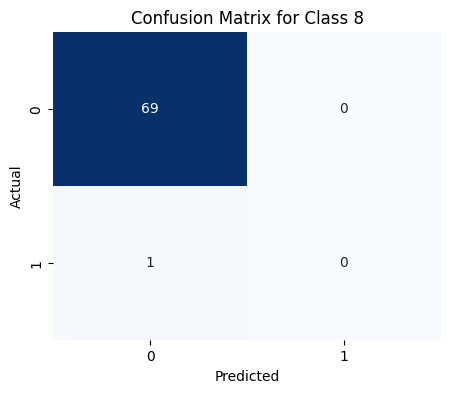

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Lakukan prediksi pada data testing
y_pred = model.predict(X_test)

# Konversi hasil prediksi ke bentuk binary (0 atau 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Menghitung confusion matrix untuk setiap kelas
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])

    # Visualisasi confusion matrix menggunakan heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [ ]:
import cv2
import json
import os

# Fungsi untuk resize gambar menjadi 10% dari ukuran aslinya
def resize_image(img, scale_percent=10):
    # Hitung dimensi baru
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # Resize gambar
    resized_img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized_img, width, height

# Fungsi untuk update anotasi koordinat
def update_annotation(annotation, scale_percent=10):
    updated_annotation = annotation.copy()

    # Hitung faktor skala
    scale_factor = scale_percent / 100

    # Jika anotasi memiliki koordinat bounding box, update koordinatnya
    if 'bbox' in annotation:
        x_min, y_min, width, height = annotation['bbox']

        updated_annotation['bbox'] = [
            x_min * scale_factor,
            y_min * scale_factor,
            width * scale_factor,
            height * scale_factor
        ]

    return updated_annotation

# Fungsi untuk proses batch resize gambar dan update anotasi
def process_images_and_annotations(annotations_file, data_folder, output_folder, scale_percent=10):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)

    updated_annotations = []

    # Proses setiap gambar dan anotasinya
    for annotation in annotations:
        img_path = os.path.join(data_folder, annotation['file_name'])
        output_img_path = os.path.join(output_folder, annotation['file_name'])

        if os.path.exists(img_path):
            img = cv2.imread(img_path)

            # Resize gambar
            resized_img, new_width, new_height = resize_image(img, scale_percent)

            # Simpan gambar yang telah di-resize
            cv2.imwrite(output_img_path, resized_img)

            # Update anotasi koordinat
            updated_annotation = update_annotation(annotation, scale_percent)
            updated_annotations.append(updated_annotation)

    return updated_annotations

# Contoh penggunaan fungsi untuk data training
updated_train_annotations = process_images_and_annotations(
    ANNOTATION_PATH + 'training.json',
    DATASET_PATH + 'training/',
    DATASET_PATH + 'training_resized/',
    scale_percent=10
)

# Simpan anotasi yang telah diperbarui ke file JSON
with open(ANNOTATION_PATH + 'training_resized.json', 'w') as f:
    json.dump(updated_train_annotations, f, indent=4)
